In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

from encoding.dataset_builder import generate_direction_encoding_dataset
from decoding.linear_decoder import train_and_eval_linear
from decoding.rate_decoder_mlp import train_rate_mlp
from decoding.snn_decoder import train_snn_decoder

plt.rcParams["figure.dpi"] = 120
plt.rcParams["font.size"] = 11


def run_experiment_static_long_T(
    T_ms=800.0,
    n_neurons=40,
    trials_per_dir=100,
    seed=0,
    save_tmp=True,
    tmp_path="exp1_static_T800.npz",
    n_epochs_mlp=40,
    n_epochs_snn=40,
):


    directions = np.arange(0, 360, 45) 
    print(f"=== Experiment 1: Static directions, T={T_ms} ms, N={n_neurons} ===")

    dataset = generate_direction_encoding_dataset(
        directions_deg=directions,
        n_neurons=n_neurons,
        trials_per_dir=trials_per_dir,
        T=T_ms,
        dt=1.0,
        r_baseline=8.0,
        r_max_mean=25.0,
        r_max_std=6.0,
        tuning_sigma_deg=50.0,
        jitter_pref_deg=7.0,
        gain_sigma=0.25,
        shared_std=3.0,
        indep_std=2.0,
        seed=seed,
    )

    spikes = dataset["spikes"]
    labels = dataset["labels"]
    directions_deg = dataset["directions_deg"]

    print("Dataset shape (spikes):", spikes.shape)

    if save_tmp:
        np.savez(
            tmp_path,
            spikes=spikes,
            labels=labels,
            directions_deg=directions_deg,
            meta=np.array([dataset["meta"]], dtype=object),
        )
        print("Saved temp dataset to:", tmp_path)
        dataset_path = tmp_path
    else:
        raise NotImplementedError("建议保存成 npz 再用解码器")


    print("\n[Experiment 1] Linear decoder (rate)")
    _, (train_acc_lin, test_acc_lin) = train_and_eval_linear(
        dataset_path=dataset_path,
        test_size=0.2,
        random_state=0,
    )


    print("\n[Experiment 1] MLP decoder (rate)")
    _, (test_acc_mlp, _) = train_rate_mlp(
        dataset_path=dataset_path,
        test_size=0.2,
        random_state=0,
        n_epochs=n_epochs_mlp,
    )


    print("\n[Experiment 1] SNN decoder (spike train)")
    _, (test_acc_snn, _) = train_snn_decoder(
        dataset_path=dataset_path,
        test_size=0.2,
        random_state=0,
        n_epochs=n_epochs_snn,
    )

    methods = ["Linear", "MLP (rate)", "SNN (spike)"]
    accs = [test_acc_lin, test_acc_mlp, test_acc_snn]

    plt.figure(figsize=(5, 4))
    plt.bar(methods, accs)
    plt.ylim(0, 1.05)
    plt.ylabel("Test accuracy")
    plt.title(f"Experiment 1: Static directions, T={T_ms} ms")
    for i, a in enumerate(accs):
        plt.text(i, a + 0.02, f"{a:.2f}", ha="center")
    plt.tight_layout()
    plt.show()

    return {
        "test_acc_lin": test_acc_lin,
        "test_acc_mlp": test_acc_mlp,
        "test_acc_snn": test_acc_snn,
    }

results_exp1 = run_experiment_static_long_T()
results_exp1


=== Experiment 2: Two-segment stimulus, T1=100.0 ms, T2=100.0 ms, N=40 ===
Dataset shape (spikes): (1600, 200, 40)
Saved temp dataset to: exp2_two_segment_T100_100.npz

[Experiment 2] Linear decoder (whole-window rate)
X_train shape: (1280, 40) X_test shape: (320, 40)
y_train distribution: {0: 162, 1: 160, 2: 152, 3: 150, 4: 171, 5: 154, 6: 159, 7: 172}
y_test  distribution: {0: 40, 1: 40, 2: 38, 3: 37, 4: 43, 5: 39, 6: 40, 7: 43}


c:\Users\Wangcs\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression train acc: 0.5242
Logistic Regression test  acc: 0.3875


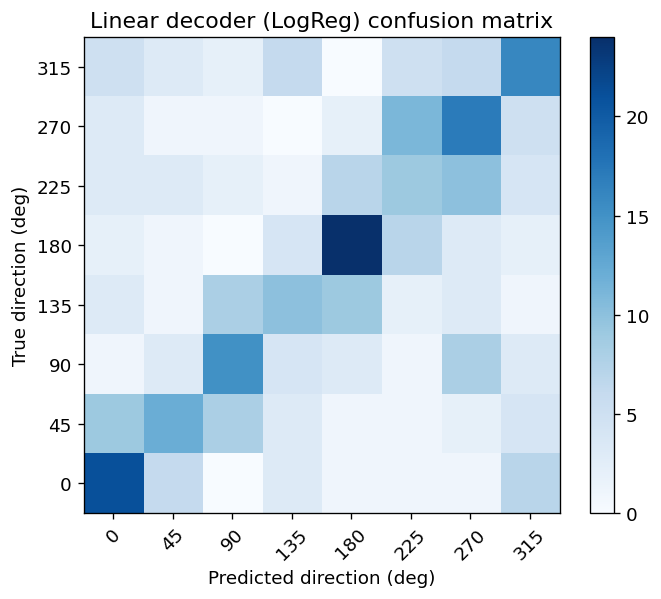


[Experiment 2] MLP decoder (whole-window rate)
Epoch   1 | loss 1.9804 | train acc 0.3383 | test acc 0.2844
Epoch   5 | loss 1.3744 | train acc 0.4711 | test acc 0.3937
Epoch  10 | loss 1.1853 | train acc 0.5820 | test acc 0.4437
Epoch  15 | loss 1.0535 | train acc 0.6398 | test acc 0.4281
Epoch  20 | loss 0.9198 | train acc 0.6930 | test acc 0.4125
Epoch  25 | loss 0.7861 | train acc 0.7461 | test acc 0.3906
Epoch  30 | loss 0.6490 | train acc 0.8164 | test acc 0.4188
Epoch  35 | loss 0.5185 | train acc 0.8711 | test acc 0.4125
Epoch  40 | loss 0.4016 | train acc 0.9141 | test acc 0.4000
Final MLP test accuracy: 0.4

[Experiment 2] SNN decoder (spike train, time-structure)
Epoch   1 | loss 5.5270 | train acc 0.1688 | test acc 0.1344
Epoch   5 | loss 1.5648 | train acc 0.3844 | test acc 0.3719
Epoch  10 | loss 1.3834 | train acc 0.4805 | test acc 0.4031
Epoch  15 | loss 1.2364 | train acc 0.5320 | test acc 0.4031
Epoch  20 | loss 1.1666 | train acc 0.5430 | test acc 0.4344
Epoch  25 |

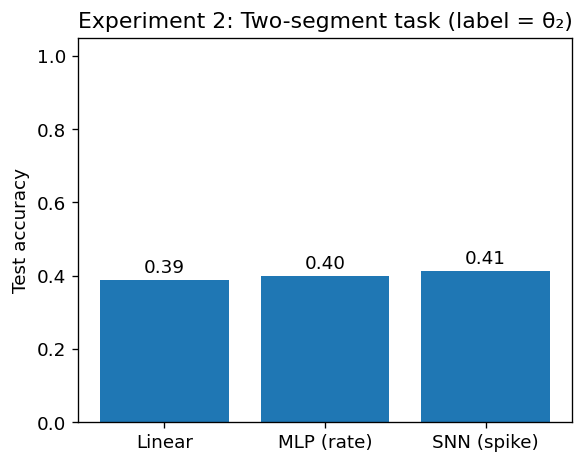

{'test_acc_lin': 0.3875, 'test_acc_mlp': 0.4, 'test_acc_snn': 0.4125}

In [ ]:
# 实验 2：短时间窗 + 方向快速变化（两段不同方向，标签为后半段方向）

from encoding.tuning import (
    generate_preferred_directions,
    sample_r_max,
    direction_tuning_gaussian,
)
from encoding.poisson_spike import poisson_population_spikes


def generate_two_segment_direction_dataset(
    directions_deg,
    n_neurons=40,
    trials_total=800,
    T1=100.0,
    T2=100.0,
    dt=1.0,
    r_baseline=8.0,
    r_max_mean=25.0,
    r_max_std=6.0,
    tuning_sigma_deg=50.0,
    jitter_pref_deg=7.0,
    gain_sigma=0.25,
    shared_std=3.0,
    indep_std=2.0,
    seed=123,
):
    rng = np.random.default_rng(seed)
    directions_deg = np.asarray(directions_deg)
    n_dirs = directions_deg.shape[0]
    T1_steps = int(T1 / dt)
    T2_steps = int(T2 / dt)
    T_steps_total = T1_steps + T2_steps

    theta_prefs = generate_preferred_directions(
        n_neurons=n_neurons,
        jitter_deg=jitter_pref_deg,
        seed=rng.integers(1_000_000_000),
    )
    r_max = sample_r_max(
        n_neurons=n_neurons,
        r_max_mean=r_max_mean,
        r_max_std=r_max_std,
        min_rate=1.0,
        max_rate=None,
        seed=rng.integers(1_000_000_000),
    )

    base_rates_all = direction_tuning_gaussian(
        theta_stim_deg=directions_deg,
        theta_pref_deg=theta_prefs,
        r_baseline=r_baseline,
        r_max=r_max,
        sigma_deg=tuning_sigma_deg,
    ) 

    spikes = np.zeros((trials_total, T_steps_total, n_neurons), dtype=np.uint8)
    labels = np.zeros(trials_total, dtype=np.int64)
    theta1_idx_all = rng.integers(low=0, high=n_dirs, size=trials_total)
    theta2_idx_all = rng.integers(low=0, high=n_dirs, size=trials_total)

    for i in range(trials_total):
        d1_idx = theta1_idx_all[i]
        d2_idx = theta2_idx_all[i]

        rates1 = base_rates_all[d1_idx].copy()
        rates2 = base_rates_all[d2_idx].copy()

        def apply_noise(rates_segment):
            rates = rates_segment.copy()
            if gain_sigma > 0.0:
                gain = rng.lognormal(mean=0.0, sigma=gain_sigma)
                rates *= gain
            if shared_std > 0.0:
                rates += rng.normal(0.0, shared_std)
            if indep_std > 0.0:
                rates += rng.normal(0.0, indep_std, size=n_neurons)
            return np.clip(rates, 0.0, None)

        rates1_noisy = apply_noise(rates1)
        rates2_noisy = apply_noise(rates2)

        spikes1 = poisson_population_spikes(
            rates_hz=rates1_noisy,
            T=T1,
            dt=dt,
            rng=rng,
        ) 
        spikes2 = poisson_population_spikes(
            rates_hz=rates2_noisy,
            T=T2,
            dt=dt,
            rng=rng,
        )  

        spikes[i, :T1_steps] = spikes1
        spikes[i, T1_steps:] = spikes2
        labels[i] = d2_idx  

    meta = {
        "T_total": T1 + T2,
        "T1": T1,
        "T2": T2,
        "dt": dt,
        "r_baseline": r_baseline,
        "r_max_mean": r_max_mean,
        "r_max_std": r_max_std,
        "tuning_sigma_deg": tuning_sigma_deg,
        "jitter_pref_deg": jitter_pref_deg,
        "gain_sigma": gain_sigma,
        "shared_std": shared_std,
        "indep_std": indep_std,
        "n_neurons": n_neurons,
        "trials_total": trials_total,
        "seed": seed,
        "task": "decode_second_segment_direction",
    }

    return {
        "spikes": spikes,
        "labels": labels,
        "directions_deg": directions_deg,
        "theta_prefs": theta_prefs,
        "r_max": r_max,
        "meta": meta,
    }


def run_experiment_two_segment(
    T1=100.0,
    T2=100.0,
    n_neurons=40,
    trials_total=1600,
    seed=1,
    tmp_path="exp2_two_segment_T100_100.npz",
    n_epochs_mlp=40,
    n_epochs_snn=40,
):

    directions = np.arange(0, 360, 45)
    print(
        f"=== Experiment 2: Two-segment stimulus, "
        f"T1={T1} ms, T2={T2} ms, N={n_neurons} ==="
    )

    dataset = generate_two_segment_direction_dataset(
        directions_deg=directions,
        n_neurons=n_neurons,
        trials_total=trials_total,
        T1=T1,
        T2=T2,
        dt=1.0,
        seed=seed,
    )

    spikes = dataset["spikes"]
    labels = dataset["labels"]
    directions_deg = dataset["directions_deg"]
    print("Dataset shape (spikes):", spikes.shape)

    np.savez(
        tmp_path,
        spikes=spikes,
        labels=labels,
        directions_deg=directions_deg,
        meta=np.array([dataset["meta"]], dtype=object),
    )
    print("Saved temp dataset to:", tmp_path)

    print("\n[Experiment 2] Linear decoder (whole-window rate)")
    _, (train_acc_lin, test_acc_lin) = train_and_eval_linear(
        dataset_path=tmp_path,
        test_size=0.2,
        random_state=0,
    )

    print("\n[Experiment 2] MLP decoder (whole-window rate)")
    _, (test_acc_mlp, _) = train_rate_mlp(
        dataset_path=tmp_path,
        test_size=0.2,
        random_state=0,
        n_epochs=n_epochs_mlp,
    )

    print("\n[Experiment 2] SNN decoder (spike train, time-structure)")
    _, (test_acc_snn, _) = train_snn_decoder(
        dataset_path=tmp_path,
        test_size=0.2,
        random_state=0,
        n_epochs=n_epochs_snn,
    )

    methods = ["Linear", "MLP (rate)", "SNN (spike)"]
    accs = [test_acc_lin, test_acc_mlp, test_acc_snn]

    plt.figure(figsize=(5, 4))
    plt.bar(methods, accs)
    plt.ylim(0, 1.05)
    plt.ylabel("Test accuracy")
    plt.title(f"Experiment 2: Two-segment task (label = θ₂)")
    for i, a in enumerate(accs):
        plt.text(i, a + 0.02, f"{a:.2f}", ha="center")
    plt.tight_layout()
    plt.show()

    return {
        "test_acc_lin": test_acc_lin,
        "test_acc_mlp": test_acc_mlp,
        "test_acc_snn": test_acc_snn,
    }

results_exp2 = run_experiment_two_segment()
results_exp2


In [ ]:
# ==== 实验 Notebook - 代码块 3 ====

def sweep_population_size(
    N_list=(10, 20, 40, 80),
    T_ms=400.0,
    trials_per_dir=100,
    base_seed=100,
    n_epochs_mlp=30,
    n_epochs_snn=30,
):
    directions = np.arange(0, 360, 45)
    acc_lin, acc_mlp, acc_snn = [], [], []

    for i, N in enumerate(N_list):
        print("\n" + "=" * 60)
        print(f"[Sweep N] N_neurons = {N}")
        print("=" * 60)

        dataset = generate_direction_encoding_dataset(
            directions_deg=directions,
            n_neurons=N,
            trials_per_dir=trials_per_dir,
            T=T_ms,
            dt=1.0,
            r_baseline=8.0,
            r_max_mean=25.0,
            r_max_std=6.0,
            tuning_sigma_deg=50.0,
            jitter_pref_deg=7.0,
            gain_sigma=0.25,
            shared_std=3.0,
            indep_std=2.0,
            seed=base_seed + i,
        )
        spikes, labels, directions_deg = (
            dataset["spikes"],
            dataset["labels"],
            dataset["directions_deg"],
        )
        tmp_path = f"tmp_sweep_N_{N}.npz"
        np.savez(
            tmp_path,
            spikes=spikes,
            labels=labels,
            directions_deg=directions_deg,
            meta=np.array([dataset["meta"]], dtype=object),
        )

        _, (_, test_acc_lin) = train_and_eval_linear(
            dataset_path=tmp_path,
            test_size=0.2,
            random_state=0,
        )
        acc_lin.append(test_acc_lin)

        _, (test_acc_mlp, _) = train_rate_mlp(
            dataset_path=tmp_path,
            test_size=0.2,
            random_state=0,
            n_epochs=n_epochs_mlp,
        )
        acc_mlp.append(test_acc_mlp)

        _, (test_acc_snn, _) = train_snn_decoder(
            dataset_path=tmp_path,
            test_size=0.2,
            random_state=0,
            n_epochs=n_epochs_snn,
        )
        acc_snn.append(test_acc_snn)

        os.remove(tmp_path)

    N_arr = np.array(N_list, dtype=int)
    return N_arr, np.array(acc_lin), np.array(acc_mlp), np.array(acc_snn)


def sweep_tuning_sigma(
    sigma_list=(30.0, 45.0, 60.0),
    T_ms=400.0,
    n_neurons=40,
    trials_per_dir=100,
    base_seed=200,
    n_epochs_mlp=30,
    n_epochs_snn=30,
):
    directions = np.arange(0, 360, 45)
    acc_lin, acc_mlp, acc_snn = [], [], []

    for i, sigma in enumerate(sigma_list):
        print("\n" + "=" * 60)
        print(f"[Sweep sigma] sigma = {sigma} deg")
        print("=" * 60)

        dataset = generate_direction_encoding_dataset(
            directions_deg=directions,
            n_neurons=n_neurons,
            trials_per_dir=trials_per_dir,
            T=T_ms,
            dt=1.0,
            r_baseline=8.0,
            r_max_mean=25.0,
            r_max_std=6.0,
            tuning_sigma_deg=sigma,
            jitter_pref_deg=7.0,
            gain_sigma=0.25,
            shared_std=3.0,
            indep_std=2.0,
            seed=base_seed + i,
        )
        spikes, labels, directions_deg = (
            dataset["spikes"],
            dataset["labels"],
            dataset["directions_deg"],
        )
        tmp_path = f"tmp_sweep_sigma_{int(sigma)}.npz"
        np.savez(
            tmp_path,
            spikes=spikes,
            labels=labels,
            directions_deg=directions_deg,
            meta=np.array([dataset["meta"]], dtype=object),
        )

        _, (_, test_acc_lin) = train_and_eval_linear(
            dataset_path=tmp_path,
            test_size=0.2,
            random_state=0,
        )
        acc_lin.append(test_acc_lin)

        _, (test_acc_mlp, _) = train_rate_mlp(
            dataset_path=tmp_path,
            test_size=0.2,
            random_state=0,
            n_epochs=n_epochs_mlp,
        )
        acc_mlp.append(test_acc_mlp)

        _, (test_acc_snn, _) = train_snn_decoder(
            dataset_path=tmp_path,
            test_size=0.2,
            random_state=0,
            n_epochs=n_epochs_snn,
        )
        acc_snn.append(test_acc_snn)

        os.remove(tmp_path)

    sigma_arr = np.array(sigma_list, dtype=float)
    return sigma_arr, np.array(acc_lin), np.array(acc_mlp), np.array(acc_snn)


def sweep_noise_level(
    noise_levels=(0.0, 0.2, 0.4),
    T_ms=400.0,
    n_neurons=40,
    trials_per_dir=100,
    base_seed=300,
    n_epochs_mlp=30,
    n_epochs_snn=30,
):
    directions = np.arange(0, 360, 45)
    acc_lin, acc_mlp, acc_snn = [], [], []

    for i, nl in enumerate(noise_levels):
        print("\n" + "=" * 60)
        print(f"[Sweep noise] noise_level = {nl}")
        print("=" * 60)

        dataset = generate_direction_encoding_dataset(
            directions_deg=directions,
            n_neurons=n_neurons,
            trials_per_dir=trials_per_dir,
            T=T_ms,
            dt=1.0,
            r_baseline=8.0,
            r_max_mean=25.0,
            r_max_std=6.0,
            tuning_sigma_deg=50.0,
            jitter_pref_deg=7.0,
            gain_sigma=nl,
            shared_std=3.0 * nl,
            indep_std=2.0 * nl,
            seed=base_seed + i,
        )
        spikes, labels, directions_deg = (
            dataset["spikes"],
            dataset["labels"],
            dataset["directions_deg"],
        )
        tmp_path = f"tmp_sweep_noise_{nl:.1f}.npz"
        np.savez(
            tmp_path,
            spikes=spikes,
            labels=labels,
            directions_deg=directions_deg,
            meta=np.array([dataset["meta"]], dtype=object),
        )


        _, (_, test_acc_lin) = train_and_eval_linear(
            dataset_path=tmp_path,
            test_size=0.2,
            random_state=0,
        )
        acc_lin.append(test_acc_lin)

        _, (test_acc_mlp, _) = train_rate_mlp(
            dataset_path=tmp_path,
            test_size=0.2,
            random_state=0,
            n_epochs=n_epochs_mlp,
        )
        acc_mlp.append(test_acc_mlp)

        _, (test_acc_snn, _) = train_snn_decoder(
            dataset_path=tmp_path,
            test_size=0.2,
            random_state=0,
            n_epochs=n_epochs_snn,
        )
        acc_snn.append(test_acc_snn)

        os.remove(tmp_path)

    nl_arr = np.array(noise_levels, dtype=float)
    return nl_arr, np.array(acc_lin), np.array(acc_mlp), np.array(acc_snn)



N_arr, accN_lin, accN_mlp, accN_snn = sweep_population_size()
sigma_arr, accS_lin, accS_mlp, accS_snn = sweep_tuning_sigma()
nl_arr, accNoise_lin, accNoise_mlp, accNoise_snn = sweep_noise_level()

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

ax = axes[0]
ax.plot(N_arr, accN_lin,  marker="o", linestyle="-",  label="Linear")
ax.plot(N_arr, accN_mlp,  marker="s", linestyle="--", label="MLP (rate)")
ax.plot(N_arr, accN_snn,  marker="D", linestyle="-.", label="SNN (spike)")
ax.set_xlabel("Number of neurons (N)")
ax.set_ylabel("Test accuracy")
ax.set_title("Population size sweep")
ax.set_ylim(0, 1.05)
ax.grid(True, alpha=0.3)
ax.legend()

ax = axes[1]
ax.plot(sigma_arr, accS_lin,  marker="o", linestyle="-",  label="Linear")
ax.plot(sigma_arr, accS_mlp,  marker="s", linestyle="--", label="MLP (rate)")
ax.plot(sigma_arr, accS_snn,  marker="D", linestyle="-.", label="SNN (spike)")
ax.set_xlabel("Tuning width σ (deg)")
ax.set_title("Tuning width sweep")
ax.set_ylim(0, 1.05)
ax.grid(True, alpha=0.3)


ax = axes[2]
ax.plot(nl_arr, accNoise_lin,  marker="o", linestyle="-",  label="Linear")
ax.plot(nl_arr, accNoise_mlp,  marker="s", linestyle="--", label="MLP (rate)")
ax.plot(nl_arr, accNoise_snn,  marker="D", linestyle="-.", label="SNN (spike)")
ax.set_xlabel("Noise level (relative)")
ax.set_title("Noise sweep")
ax.set_ylim(0, 1.05)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
#加噪工具函数
import numpy as np

def add_gaussian_noise_to_spikes(npz_in, npz_out, noise_sigma, clip=True, seed=0):
    rng = np.random.default_rng(seed)
    
    data = np.load(npz_in, allow_pickle=True)
    
    spikes = data["spikes"].astype(np.float32)
    spikecounts = data["spikecounts"]
    labels = data["labels"]
    directions_deg = data["directions_deg"]
    session_idx = data.get("session_idx")
    meta = data["meta"]

    print("Original spikes shape:", spikes.shape)

    noise = rng.normal(loc=0.0, scale=noise_sigma, size=spikes.shape)
    spikes_noisy = spikes + noise

    if clip:
        spikes_noisy = np.clip(spikes_noisy, 0.0, 1.0)

    np.savez(
        npz_out,
        spikes=spikes_noisy,
        spikecounts=spikecounts,
        labels=labels,
        directions_deg=directions_deg,
        session_idx=session_idx,
        meta=meta
    )

    print(f"[OK] Saved noisy dataset → {npz_out}")


In [ ]:
#小session解码实验汇总
import os
import numpy as np
import matplotlib.pyplot as plt

from decoding.linear_decoder import train_and_eval_linear
from decoding.rate_decoder_mlp import train_rate_mlp
from decoding.snn_decoder import train_snn_decoder

base_dir = r"D:\Neuron Science\FinPro\npz_data" 
session_ids = list(range(22))
test_size = 0.2
random_state = 0

mlp_epochs = 40
snn_epochs = 40

linear_accs = []
mlp_accs = []
snn_accs = []
used_sessions = [] 

for sid in session_ids:
    fname = f"HenryKohn2022_distractorseparation_session{sid}_v4.npz"
    dataset_path = os.path.join(base_dir, fname)

    if not os.path.exists(dataset_path):
        print(f"[Session {sid}] 文件不存在，跳过: {dataset_path}")
        continue

    print(f"\n================ Session {sid} ================")
    print(f"加载数据: {dataset_path}")

    # ----- Linear (rate-based baseline) -----
    try:
        _, (train_acc_lin, test_acc_lin) = train_and_eval_linear(
            dataset_path=dataset_path,
            test_size=test_size,
            random_state=random_state,
        )
        print(f"[Session {sid}] Linear   test acc = {test_acc_lin:.4f}")
    except Exception as e:
        print(f"[Session {sid}] Linear 训练/测试出错：{e}")
        test_acc_lin = np.nan

    try:
        _, (test_acc_mlp, _) = train_rate_mlp(
            dataset_path=dataset_path,
            test_size=test_size,
            random_state=random_state,
            n_epochs=mlp_epochs,
        )
        print(f"[Session {sid}] MLP      test acc = {test_acc_mlp:.4f}")
    except Exception as e:
        print(f"[Session {sid}] MLP 训练/测试出错：{e}")
        test_acc_mlp = np.nan
    try:
        _, (test_acc_snn, _) = train_snn_decoder(
            dataset_path=dataset_path,
            test_size=test_size,
            random_state=random_state,
            n_epochs=snn_epochs,
        )
        print(f"[Session {sid}] SNN      test acc = {test_acc_snn:.4f}")
    except Exception as e:
        print(f"[Session {sid}] SNN 训练/测试出错：{e}")
        test_acc_snn = np.nan

    used_sessions.append(sid)
    linear_accs.append(test_acc_lin)
    mlp_accs.append(test_acc_mlp)
    snn_accs.append(test_acc_snn)

used_sessions = np.array(used_sessions)
linear_accs = np.array(linear_accs, dtype=float)
mlp_accs = np.array(mlp_accs, dtype=float)
snn_accs = np.array(snn_accs, dtype=float)

print("\n========== 总结 ==========")
for sid, la, ma, sa in zip(used_sessions, linear_accs, mlp_accs, snn_accs):
    print(f"Session {sid:2d} | Linear: {la:.4f} | MLP: {ma:.4f} | SNN: {sa:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(used_sessions, linear_accs, marker="o", label="Linear (rate)")
plt.plot(used_sessions, mlp_accs, marker="s", label="MLP (rate)")
plt.plot(used_sessions, snn_accs, marker="^", label="SNN (spike)")
plt.xlabel("Session ID")
plt.ylabel("Test accuracy")
plt.title("V4 distractor-orientation: per-session decoding performance")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [3]:
add_gaussian_noise_to_spikes(
    npz_in="D:\\Neuron Science\\FinPro\\npz_data\\HenryKohn2022_distractororientation_all_sessions_v4.npz",
    npz_out="D:\\Neuron Science\\FinPro\\npz_data\\HenryKohn2022_distractororientation_all_sessions_v4_noisy.npz",
    noise_sigma=0.1)

Original spikes shape: (9332, 50, 23)
[OK] Saved noisy dataset → D:\Neuron Science\FinPro\npz_data\HenryKohn2022_distractororientation_all_sessions_v4_noisy.npz


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

import torch
import torch.nn as nn
import torch.optim as optim

from decoding.snn_decoder import SNNDirectionDecoder

clean_npz = r"D:\Neuron Science\FinPro\npz_data\HenryKohn2022_distractororientation_all_sessions_v4_noisy.npz"
data_clean = np.load(clean_npz, allow_pickle=True)

spikes_clean = data_clean["spikes"].astype(np.float32)   # (N, T, C)
labels = data_clean["labels"].astype(np.int64)
directions_deg = data_clean["directions_deg"]

N, T_steps, N_neurons = spikes_clean.shape
print("Clean spikes:", spikes_clean.shape)

train_idx, test_idx = train_test_split(
    np.arange(N),
    test_size=0.3,
    stratify=labels,
    random_state=0,
)

labels_train = labels[train_idx]
labels_test  = labels[test_idx]

spikes_train_clean = spikes_clean[train_idx]
spikes_test_clean  = spikes_clean[test_idx]

X_test_rate_clean = spikes_test_clean.mean(axis=1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_snn_on_data(spikes_train, labels_train,
                      spikes_test_clean, labels_test,
                      hidden_size=128, beta=0.9,
                      n_epochs=20, lr=1e-3, batch_size=64):

    model = SNNDirectionDecoder(
        input_size=spikes_train.shape[2],
        hidden_size=hidden_size,
        n_classes=len(np.unique(labels_train)),
        beta=beta,
    ).to(device)

    train_ds = torch.utils.data.TensorDataset(
        torch.tensor(spikes_train, dtype=torch.float32),
        torch.tensor(labels_train, dtype=torch.long),
    )
    test_ds = torch.utils.data.TensorDataset(
        torch.tensor(spikes_test_clean, dtype=torch.float32),
        torch.tensor(labels_test, dtype=torch.long),
    )

    train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_loader  = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    def eval_acc():
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                preds = torch.argmax(logits, dim=1)
                all_preds.append(preds.cpu().numpy())
                all_labels.append(yb.cpu().numpy())
        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)
        return accuracy_score(all_labels, all_preds)

    for ep in range(1, n_epochs + 1):
        model.train()
        running_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)

            logits = model(xb)
            loss = criterion(logits, yb)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        if ep % 5 == 0 or ep == 1:
            acc = eval_acc()
            print(f"[SNN] epoch {ep:2d} | loss={running_loss/len(train_loader):.4f} | test_acc={acc:.3f}")

    final_acc = eval_acc()
    return final_acc, model

noise_levels = [0.0, 0.05, 0.1, 0.15, 0.2]

acc_linear = []
acc_mlp = []
acc_snn = []

for sigma in noise_levels:
    print("\n==============================")
    print(f"Training with noise_sigma = {sigma:.2f}")
    print("==============================")

    if sigma == 0.0:
        spikes_train_noisy = spikes_train_clean.copy()
    else:
        noisy_npz = clean_npz.replace(".npz", f"_trainnoise_sigma{sigma:.2f}.npz")
        add_gaussian_noise_to_spikes(
            npz_in=clean_npz,
            npz_out=noisy_npz,
            noise_sigma=sigma,
            clip=True,
            seed=0,
        )
        noisy_data = np.load(noisy_npz, allow_pickle=True)
        spikes_noisy_all = noisy_data["spikes"].astype(np.float32)
        spikes_train_noisy = spikes_noisy_all[train_idx]

    # --------- Linear ---------
    X_train_rate_noisy = spikes_train_noisy.mean(axis=1)
    linear_clf = LogisticRegression(max_iter=2000)
    linear_clf.fit(X_train_rate_noisy, labels_train)
    y_pred_lin = linear_clf.predict(X_test_rate_clean)
    acc_l = accuracy_score(labels_test, y_pred_lin)
    acc_linear.append(acc_l)
    print(f"[sigma={sigma:.2f}] Linear acc on CLEAN test = {acc_l:.3f}")

    # --------- MLP ---------
    mlp_clf = MLPClassifier(hidden_layer_sizes=(128, 64),
                            activation="relu",
                            max_iter=2000)
    mlp_clf.fit(X_train_rate_noisy, labels_train)
    y_pred_mlp = mlp_clf.predict(X_test_rate_clean)
    acc_m = accuracy_score(labels_test, y_pred_mlp)
    acc_mlp.append(acc_m)
    print(f"[sigma={sigma:.2f}] MLP    acc on CLEAN test = {acc_m:.3f}")

    # --------- SNN ---------
    acc_s, _ = train_snn_on_data(
        spikes_train=spikes_train_noisy,
        labels_train=labels_train,
        spikes_test_clean=spikes_test_clean,
        labels_test=labels_test,
        hidden_size=128,
        beta=0.9,
        n_epochs=20,
        lr=1e-3,
        batch_size=64,
    )
    acc_snn.append(acc_s)
    print(f"[sigma={sigma:.2f}] SNN    acc on CLEAN test = {acc_s:.3f}")

plt.figure(figsize=(7,5))
plt.plot(noise_levels, acc_mlp,   "-o", label="MLP (rate)", linewidth=2)
plt.plot(noise_levels, acc_snn,   "-o", label="SNN (spike train)", linewidth=2)

plt.xlabel("Training Gaussian Noise σ")
plt.ylabel("Accuracy")
plt.title("Robustness to Training Noise (test on clean data)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


Clean spikes: (9332, 50, 23)

Training with noise_sigma = 0.00
[sigma=0.00] Linear acc on CLEAN test = 0.875
[sigma=0.00] MLP    acc on CLEAN test = 0.831
[SNN] epoch  1 | loss=0.4373 | test_acc=0.875
[SNN] epoch  5 | loss=0.3844 | test_acc=0.875
[SNN] epoch 10 | loss=0.3740 | test_acc=0.875
[SNN] epoch 15 | loss=0.3743 | test_acc=0.875
[SNN] epoch 20 | loss=0.3737 | test_acc=0.875
[sigma=0.00] SNN    acc on CLEAN test = 0.875

Training with noise_sigma = 0.05
Original spikes shape: (9332, 50, 23)
[OK] Saved noisy dataset → D:\Neuron Science\FinPro\npz_data\HenryKohn2022_distractororientation_all_sessions_v4_noisy_trainnoise_sigma0.05.npz
[sigma=0.05] Linear acc on CLEAN test = 0.875
[sigma=0.05] MLP    acc on CLEAN test = 0.875
[SNN] epoch  1 | loss=0.4044 | test_acc=0.875
[SNN] epoch  5 | loss=0.3787 | test_acc=0.875
[SNN] epoch 10 | loss=0.3752 | test_acc=0.875
[SNN] epoch 15 | loss=0.3742 | test_acc=0.875
[SNN] epoch 20 | loss=0.3765 | test_acc=0.874
[sigma=0.05] SNN    acc on CLEA

In [20]:
#打印HenryKohn2022_distractororientation_all_sessions_v4.npz数据集中的内容
data = np.load(npz_path, allow_pickle=True)
print("数据集包含的键：", data.files)   
for key in data.files:
    print(f"\n键: {key}")
    print("内容:", data[key])
    print("形状:", data[key].shape if hasattr(data[key], 'shape') else 'N/A')
    print("数据类型:", data[key].dtype if hasattr(data[key], 'dtype') else  'N/A')
    

数据集包含的键： ['spikes', 'spikecounts', 'labels', 'directions_deg', 'session_idx', 'meta']

键: spikes
内容: [[[0.08 0.1  0.06 ... 0.04 0.14 0.04]
  [0.08 0.1  0.06 ... 0.04 0.14 0.04]
  [0.08 0.1  0.06 ... 0.04 0.14 0.04]
  ...
  [0.08 0.1  0.06 ... 0.04 0.14 0.04]
  [0.08 0.1  0.06 ... 0.04 0.14 0.04]
  [0.08 0.1  0.06 ... 0.04 0.14 0.04]]

 [[0.06 0.08 0.08 ... 0.06 0.06 0.1 ]
  [0.06 0.08 0.08 ... 0.06 0.06 0.1 ]
  [0.06 0.08 0.08 ... 0.06 0.06 0.1 ]
  ...
  [0.06 0.08 0.08 ... 0.06 0.06 0.1 ]
  [0.06 0.08 0.08 ... 0.06 0.06 0.1 ]
  [0.06 0.08 0.08 ... 0.06 0.06 0.1 ]]

 [[0.14 0.14 0.08 ... 0.18 0.08 0.14]
  [0.14 0.14 0.08 ... 0.18 0.08 0.14]
  [0.14 0.14 0.08 ... 0.18 0.08 0.14]
  ...
  [0.14 0.14 0.08 ... 0.18 0.08 0.14]
  [0.14 0.14 0.08 ... 0.18 0.08 0.14]
  [0.14 0.14 0.08 ... 0.18 0.08 0.14]]

 ...

 [[0.06 0.02 0.3  ... 0.18 0.   0.12]
  [0.06 0.02 0.3  ... 0.18 0.   0.12]
  [0.06 0.02 0.3  ... 0.18 0.   0.12]
  ...
  [0.06 0.02 0.3  ... 0.18 0.   0.12]
  [0.06 0.02 0.3  ... 0.18 

In [ ]:

# Neuron population analysis & visualization
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

npz_path = r"D:\Neuron Science\FinPro\npz_data\HenryKohn2022_distractororientation_all_sessions_v4.npz"
data = np.load(npz_path, allow_pickle=True)

spikes = data["spikes"]             # (N_trials, T_steps, N_neurons)
labels = data["labels"]             # (N_trials,)
directions_deg = data["directions_deg"]  # (n_dirs,)
meta = data["meta"][0]
print("spikes:", spikes.shape)
print("labels:", labels.shape)
print("directions_deg:", directions_deg)

N_trials, T_steps, N_neurons = spikes.shape
n_dirs = len(directions_deg)

# 1. 估计每个 neuron 的 tuning & preferred direction
tuning_matrix = np.zeros((n_dirs, N_neurons), dtype=float)

for d_idx, theta in enumerate(directions_deg):
    # 这里假定 labels 是方向索引 0..n_dirs-1，对应 directions_deg 的 index
    trial_mask = (labels == d_idx)
    if np.sum(trial_mask) == 0:
        continue
    tuning_matrix[d_idx] = spikes[trial_mask].mean(axis=(0, 1))

preferred_dir_idx = np.argmax(tuning_matrix, axis=0)   
preferred_dir_deg = directions_deg[preferred_dir_idx] 

tuning_max = tuning_matrix.max(axis=0)
tuning_min = tuning_matrix.min(axis=0)
tuning_mean = tuning_matrix.mean(axis=0)
tuning_contrast = tuning_max - tuning_min  
tuning_selectivity = np.where(tuning_mean > 0, tuning_max / (tuning_mean + 1e-6), 0)

print("Preferred directions per neuron (deg):", preferred_dir_deg[:10], "...")

# 2. 对 neuron 做 PCA / t-SNE 可视化

neuron_features = tuning_matrix.T  # 每一行是一个 neuron 在各方向上的 tuning


pca = PCA(n_components=2)
neuron_pca = pca.fit_transform(neuron_features) 

tsne = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=20.0)
neuron_tsne = tsne.fit_transform(neuron_features)

norm_pd = (preferred_dir_deg - preferred_dir_deg.min()) / (np.ptp(preferred_dir_deg) + 1e-6)


plt.figure(figsize=(6, 5))
plt.scatter(neuron_pca[:, 0], neuron_pca[:, 1],
            c=preferred_dir_deg, cmap="hsv", s=25)
plt.colorbar(label="Preferred direction (deg)")
plt.title("Neuron PCA (colored by preferred direction)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))
plt.scatter(neuron_tsne[:, 0], neuron_tsne[:, 1],
            c=preferred_dir_deg, cmap="hsv", s=25)
plt.colorbar(label="Preferred direction (deg)")
plt.title("Neuron t-SNE (colored by preferred direction)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.show()


Loaded spikes: (9332, 50, 23)
Linear full-window accuracy: 0.875
MLP full-window accuracy: 0.79
Finished quick SNN training!
t=1/50  acc_snn=0.875  acc_mlp=0.770
t=2/50  acc_snn=0.875  acc_mlp=0.767
t=3/50  acc_snn=0.860  acc_mlp=0.774
t=4/50  acc_snn=0.833  acc_mlp=0.783
t=5/50  acc_snn=0.839  acc_mlp=0.775
t=6/50  acc_snn=0.864  acc_mlp=0.782
t=7/50  acc_snn=0.870  acc_mlp=0.785
t=8/50  acc_snn=0.871  acc_mlp=0.775
t=9/50  acc_snn=0.871  acc_mlp=0.780
t=10/50  acc_snn=0.873  acc_mlp=0.767
t=11/50  acc_snn=0.875  acc_mlp=0.779
t=12/50  acc_snn=0.874  acc_mlp=0.778
t=13/50  acc_snn=0.875  acc_mlp=0.781
t=14/50  acc_snn=0.875  acc_mlp=0.775
t=15/50  acc_snn=0.875  acc_mlp=0.778
t=16/50  acc_snn=0.875  acc_mlp=0.776
t=17/50  acc_snn=0.875  acc_mlp=0.779
t=18/50  acc_snn=0.875  acc_mlp=0.780
t=19/50  acc_snn=0.874  acc_mlp=0.782
t=20/50  acc_snn=0.875  acc_mlp=0.781
t=21/50  acc_snn=0.875  acc_mlp=0.775
t=22/50  acc_snn=0.875  acc_mlp=0.777
t=23/50  acc_snn=0.875  acc_mlp=0.778
t=24/50  a

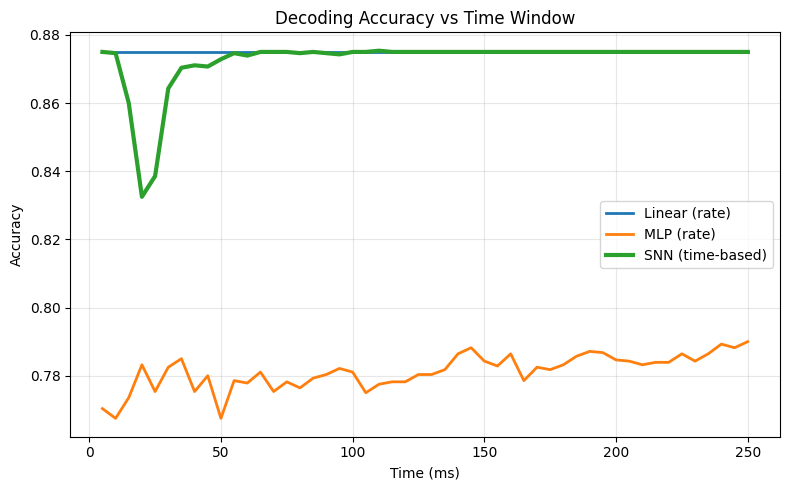

In [ ]:
# Latency & Time Window Experiment: Accuracy over Time
import numpy as np
import torch
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

npz_path = "D:\\Neuron Science\\FinPro\\npz_data\\HenryKohn2022_distractororientation_all_sessions_v4_noisy.npz"
data = np.load(npz_path, allow_pickle=True)

spikes = data["spikes"].astype(np.float32)     # (N_trials, T_steps, N_neurons)
labels = data["labels"].astype(int)
directions_deg = data["directions_deg"]

N_trials, T_steps, N_neurons = spikes.shape
print("Loaded spikes:", spikes.shape)

from sklearn.model_selection import train_test_split
train_idx, test_idx = train_test_split(
    np.arange(N_trials),
    test_size=0.3,
    stratify=labels,
    random_state=0
)

spikes_train = spikes[train_idx]
spikes_test  = spikes[test_idx]
labels_train = labels[train_idx]
labels_test  = labels[test_idx]


X_train_full = spikes_train.mean(axis=1)   # average rate over full window
X_test_full  = spikes_test.mean(axis=1)

clf_linear = LogisticRegression(max_iter=2000)
clf_linear.fit(X_train_full, labels_train)
print("Linear full-window accuracy:", clf_linear.score(X_test_full, labels_test))

mlp = MLPClassifier(hidden_layer_sizes=(128,64), max_iter=2000)
mlp.fit(X_train_full, labels_train)
print("MLP full-window accuracy:", mlp.score(X_test_full, labels_test))

from decoding.snn_decoder import SNNDirectionDecoder
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

snn = SNNDirectionDecoder(
    input_size=N_neurons,
    hidden_size=128,
    n_classes=len(directions_deg),
    beta=0.9
).to(device)

# Convert training data to torch for simple SGD
train_tensor = torch.tensor(spikes_train, device=device)
label_tensor = torch.tensor(labels_train, device=device)

criterion = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(snn.parameters(), lr=1e-3)

# SNN quick training (10 epochs for demonstration)
for ep in range(10):
    opt.zero_grad()
    logits = snn(train_tensor)
    loss = criterion(logits, label_tensor)
    loss.backward()
    opt.step()
print("Finished quick SNN training!")


acc_linear = []
acc_mlp = []
acc_snn = []

for t in range(1, T_steps + 1):

    rate_train = spikes_train[:, :t, :].mean(axis=1)
    rate_test  = spikes_test[:, :t, :].mean(axis=1)

    pred_lin = clf_linear.predict(rate_test)
    acc_linear.append(accuracy_score(labels_test, pred_lin))

    pred_mlp = mlp.predict(rate_test)
    acc_mlp.append(accuracy_score(labels_test, pred_mlp))

    with torch.no_grad():
        test_slice = torch.tensor(spikes_test[:, :t, :], device=device)
        logits = snn(test_slice)
        pred = torch.argmax(logits, dim=1).cpu().numpy()
        acc_snn.append(accuracy_score(labels_test, pred))

    print(f"t={t}/{T_steps}  acc_snn={acc_snn[-1]:.3f}  acc_mlp={acc_mlp[-1]:.3f}")

import matplotlib.pyplot as plt

time_axis = np.arange(1, T_steps+1) * 5

plt.figure(figsize=(8,5))
plt.plot(time_axis, acc_linear, label="Linear (rate)", linewidth=2)
plt.plot(time_axis, acc_mlp, label="MLP (rate)", linewidth=2)
plt.plot(time_axis, acc_snn, label="SNN (time-based)", linewidth=3)

plt.xlabel("Time (ms)")
plt.ylabel("Accuracy")
plt.title("Decoding Accuracy vs Time Window")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


spikes: (9332, 50, 23) labels: (9332,)

=== Train SNN: no dropout, no L2 ===
[SNN ep  1] loss=0.4818 | test_acc=0.8750
[SNN ep 10] loss=0.3768 | test_acc=0.8746
[SNN ep 20] loss=0.3678 | test_acc=0.8750
[SNN ep 30] loss=0.3666 | test_acc=0.8746

=== Train SNN: dropout only ===
[SNN ep  1] loss=0.4495 | test_acc=0.8750
[SNN ep 10] loss=0.3769 | test_acc=0.8750
[SNN ep 20] loss=0.3683 | test_acc=0.8750
[SNN ep 30] loss=0.3674 | test_acc=0.8750

=== Train SNN: dropout + L2 ===
[SNN ep  1] loss=0.4915 | test_acc=0.8750
[SNN ep 10] loss=0.3784 | test_acc=0.8750
[SNN ep 20] loss=0.3735 | test_acc=0.8750
[SNN ep 30] loss=0.3697 | test_acc=0.8750

=== Ablation Results ===
Linear (rate)        : 0.8750
MLP (rate)           : 0.7979
SNN (plain)          : 0.8746
SNN (+Dropout)       : 0.8750
SNN (+Dropout+L2)    : 0.8750


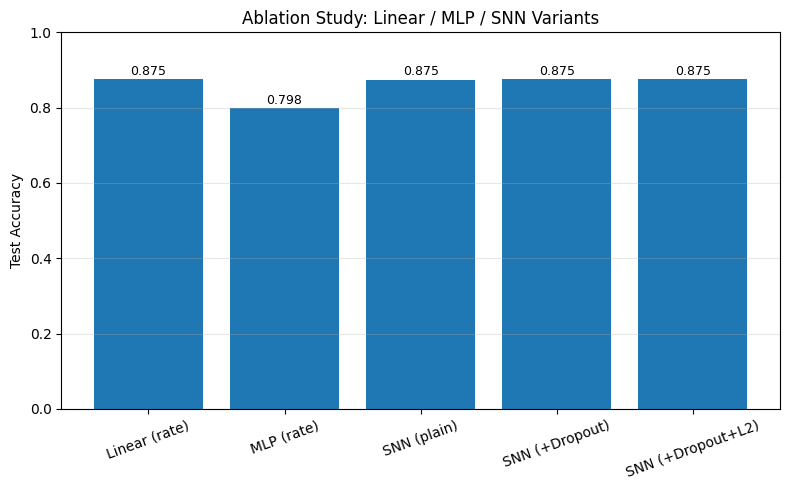

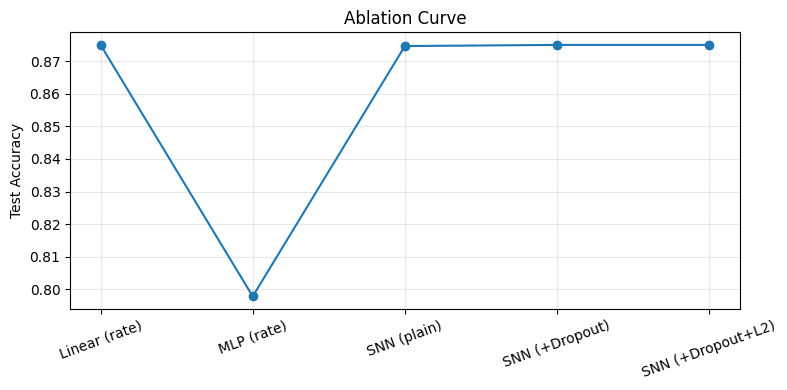

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
import snntorch as snn
from snntorch import surrogate

npz_path = r"D:\Neuron Science\FinPro\npz_data\HenryKohn2022_distractororientation_all_sessions_v4_noisy.npz"
data = np.load(npz_path, allow_pickle=True)

spikes = data["spikes"].astype(np.float32)   # (N_trials, T_steps, N_neurons)
labels = data["labels"].astype(np.int64)
directions_deg = data["directions_deg"]

N_trials, T_steps, N_neurons = spikes.shape
print("spikes:", spikes.shape, "labels:", labels.shape)
train_idx, test_idx = train_test_split(
    np.arange(N_trials),
    test_size=0.3,
    stratify=labels,
    random_state=0,
)

spikes_train = spikes[train_idx]
spikes_test  = spikes[test_idx]
labels_train = labels[train_idx]
labels_test  = labels[test_idx]

X_train_rate = spikes_train.mean(axis=1)   # (N_train, N_neurons)
X_test_rate  = spikes_test.mean(axis=1)
spike_grad = surrogate.fast_sigmoid(slope=25.0)

class SNNDirectionDecoder(nn.Module):
    def __init__(self, input_size, hidden_size, n_classes, beta=0.9, dropout_p=0.0):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout = nn.Dropout(dropout_p) if dropout_p > 0 else nn.Identity()
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.fc2 = nn.Linear(hidden_size, n_classes)

    def forward(self, x):
        batch_size, T_steps, _ = x.shape
        mem1 = self.lif1.init_leaky()
        out_rec = []

        for t in range(T_steps):
            x_t = x[:, t, :]
            h = self.fc1(x_t)
            h = self.dropout(h)
            spk, mem1 = self.lif1(h, mem1)
            out = self.fc2(spk)
            out_rec.append(out.unsqueeze(1))

        out_rec = torch.cat(out_rec, dim=1)   # (batch, T_steps, n_classes)
        out_sum = out_rec.sum(dim=1)          # time-sum readout
        return out_sum

def train_snn_once(
    spikes_train,
    labels_train,
    spikes_test,
    labels_test,
    hidden_size=128,
    beta=0.9,
    dropout_p=0.0,
    l2_lambda=0.0,
    n_epochs=30,
    lr=1e-3,
    batch_size=64,
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SNNDirectionDecoder(
        input_size=spikes_train.shape[2],
        hidden_size=hidden_size,
        n_classes=len(np.unique(labels_train)),
        beta=beta,
        dropout_p=dropout_p,
    ).to(device)

    train_ds = torch.utils.data.TensorDataset(
        torch.tensor(spikes_train, dtype=torch.float32),
        torch.tensor(labels_train, dtype=torch.long),
    )
    test_ds = torch.utils.data.TensorDataset(
        torch.tensor(spikes_test, dtype=torch.float32),
        torch.tensor(labels_test, dtype=torch.long),
    )

    train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_loader  = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    def eval_acc():
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                preds = torch.argmax(logits, dim=1)
                all_preds.append(preds.cpu().numpy())
                all_labels.append(yb.cpu().numpy())
        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)
        return accuracy_score(all_labels, all_preds)

    for ep in range(1, n_epochs + 1):
        model.train()
        running_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            ce_loss = criterion(logits, yb)
            l2_loss = 0.0
            if l2_lambda > 0:
                for name, p in model.named_parameters():
                    if "weight" in name and p.requires_grad:
                        l2_loss = l2_loss + torch.sum(p ** 2)
                loss = ce_loss + l2_lambda * l2_loss
            else:
                loss = ce_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        if ep % 10 == 0 or ep == 1:
            test_acc = eval_acc()
            print(
                f"[SNN ep {ep:2d}] loss={running_loss/len(train_loader):.4f} "
                f"| test_acc={test_acc:.4f}"
            )

    final_acc = eval_acc()
    return final_acc, model

ablation_results = []

linear_clf = LogisticRegression(max_iter=2000)
linear_clf.fit(X_train_rate, labels_train)
y_pred_lin = linear_clf.predict(X_test_rate)
acc_lin = accuracy_score(labels_test, y_pred_lin)
ablation_results.append(("Linear (rate)", acc_lin))

mlp_clf = MLPClassifier(hidden_layer_sizes=(128, 64), activation="relu", max_iter=2000)
mlp_clf.fit(X_train_rate, labels_train)
y_pred_mlp = mlp_clf.predict(X_test_rate)
acc_mlp = accuracy_score(labels_test, y_pred_mlp)
ablation_results.append(("MLP (rate)", acc_mlp))

print("\n=== Train SNN: no dropout, no L2 ===")
acc_snn_plain, _ = train_snn_once(
    spikes_train, labels_train, spikes_test, labels_test,
    hidden_size=128,
    dropout_p=0.0,
    l2_lambda=0.0,
    n_epochs=30,
)
ablation_results.append(("SNN (plain)", acc_snn_plain))

print("\n=== Train SNN: dropout only ===")
acc_snn_dropout, _ = train_snn_once(
    spikes_train, labels_train, spikes_test, labels_test,
    hidden_size=128,
    dropout_p=0.2,
    l2_lambda=0.0,
    n_epochs=30,
)
ablation_results.append(("SNN (+Dropout)", acc_snn_dropout))

print("\n=== Train SNN: dropout + L2 ===")
acc_snn_full, _ = train_snn_once(
    spikes_train, labels_train, spikes_test, labels_test,
    hidden_size=128,
    dropout_p=0.2,
    l2_lambda=1e-4,
    n_epochs=30,
)
ablation_results.append(("SNN (+Dropout+L2)", acc_snn_full))

print("\n=== Ablation Results ===")
for name, acc in ablation_results:
    print(f"{name:20s} : {acc:.4f}")

names = [x[0] for x in ablation_results]
accs  = [x[1] for x in ablation_results]

plt.figure(figsize=(8, 5))
bars = plt.bar(names, accs)
for b, a in zip(bars, accs):
    plt.text(b.get_x() + b.get_width()/2, b.get_height()+0.005,
             f"{a:.3f}", ha="center", va="bottom", fontsize=9)

plt.ylabel("Test Accuracy")
plt.title("Ablation Study: Linear / MLP / SNN Variants")
plt.ylim(0, 1.0)
plt.grid(axis="y", alpha=0.3)
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()
